### Using the boston housing dataset

In [1]:
from keras.datasets import boston_housing


Using TensorFlow backend.


In [2]:
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

57344/57026 [==============================] - 0s 1us/step


### Normalize the data

* It would be problematic to feed into a neural network values that all take wildly different ranges. The network might be able to automatically adapt to such heterogeneous data, but it would definitely make learning more difficult. 
* A widespread best practice to deal with such data is to do feature-wise normalization: for each feature in the input data (a column in the input data matrix), you subtract the mean of the feature and divide by the standard deviation, so that the feature is centered around 0 and has a unit standard deviation.

In [3]:
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std
test_data -= mean
test_data /= std

### Define model

In [7]:
from tensorflow.keras import models
from tensorflow.keras import layers
def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

### K-fold validation

In [8]:
import numpy as np
k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []

for i in range(k):
    print('processing fold #', i)
    # Prepares the validation data: data from partition #k
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    
    # Prepares the training data: data from all other partitions
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
        train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
        train_targets[(i + 1) * num_val_samples:]],
        axis=0)
    
    # Builds the Keras model (already compiled)
    model = build_model()
    
    # Trains the model (in silent mode, verbose = 0)
    model.fit(partial_train_data, partial_train_targets,
    epochs=num_epochs, batch_size=1, verbose=0)
    
    # Evaluates the model on the validation data
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0) 
    all_scores.append(val_mae)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [9]:
all_scores

[1.9461874, 2.5530396, 2.6885576, 2.7910645]

### Saving the validation logs at each fold

In [13]:
num_epochs = 500
all_mae_histories = []
for i in range(k):
    print('processing fold #', i)
    # Prepares the validation data: data from partition #k
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    
    # Prepares the training data: data from all other partitions
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
        train_data[(i + 1) * num_val_samples:]], axis=0)

    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
        train_targets[(i + 1) * num_val_samples:]], axis=0)
    
    # Builds the Keras model (already compiled)
    model = build_model()
    
    # Trains the model (in silent mode, verbose=0)
    history = model.fit(partial_train_data, partial_train_targets,
        validation_data=(val_data, val_targets),
        epochs=num_epochs, batch_size=1, verbose=0)
    
    mae_history = history.history['val_mae']
    all_mae_histories.append(mae_history)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [14]:
history.history.keys()

dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])

### Building the history of successive mean K-fold validation scores

In [15]:
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

### Plotting validation scores

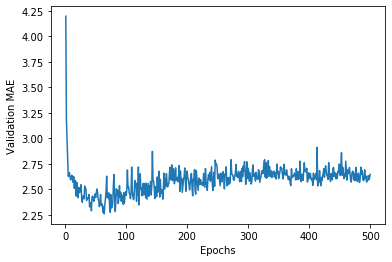

In [17]:
import matplotlib.pyplot as plt
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()


### Plotting validation scores, excluding the first 10 data points

In [20]:
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

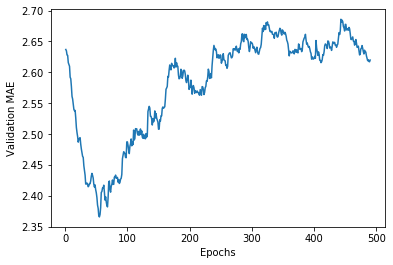

In [21]:
smooth_mae_history = smooth_curve(average_mae_history[10:])
plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

According to this plot, validation MAE stops improving significantly after 80 epochs.
Past that point, you start overfitting.

### Training the final model

In [22]:
model = build_model() # Gets a fresh, compiled model

# Trains it on the entirety of the data
model.fit(train_data, train_targets, epochs=80, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

102/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [23]:
test_mae_score


2.5544255

### Take-aways
* Regression is done using different loss functions than what we used for classification. Mean squared error (MSE) is a loss function commonly used for regression.
* Similarly, evaluation metrics to be used for regression differ from those used for classification; naturally, the concept of accuracy doesn’t apply for regression. A common regression metric is mean absolute error (MAE).
* When features in the input data have values in different ranges, each feature should be scaled independently as a preprocessing step.
* When there is little data available, using K-fold validation is a great way to reliably evaluate a model.
* When little training data is available, it’s preferable to use a small network with few hidden layers (typically only one or two), in order to avoid severe overfitting.